In [1]:
# Import dependencies 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psycopg2
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (10, 6)


cid_number = 10000 # TODO: this is hardcoded so far

con_k15 = psycopg2.connect(
    host="localhost",
    port="5432",
    database="cid_hoarder_n10k_k15",
    user="hoarder",
    password="password")

con_k15_2 = psycopg2.connect(
    host="localhost",
    port="5432",
    database="cid_hoarder_n10k_k15_2",
    user="hoarder",
    password="password")

con_k20 = psycopg2.connect(
    host="localhost",
    port="5432",
    database="cid_hoarder_n10k_k20",
    user="hoarder",
    password="password")

con_k20_2 = psycopg2.connect(
    host="localhost",
    port="5432",
    database="cid_hoarder_n10k_k20_2",
    user="hoarder",
    password="password")

con_k25 = psycopg2.connect(
    host="localhost",
    port="5432",
    database="cid_hoarder_n10k_k25",
    user="hoarder",
    password="password")

dbs = [con_k15, con_k15_2, con_k20, con_k20_2, con_k25]
db_labels = ['k=15', 'k=15_2', 'k=20', 'k=20_2', 'k=25']
box_idxs = np.arange(len(dbs))

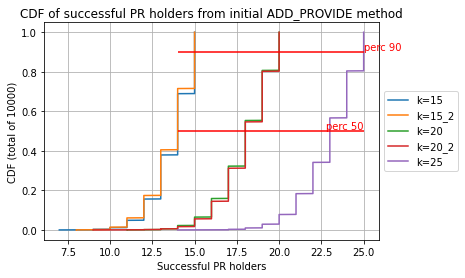

In [2]:
# Comparison of the successfull ADD_PROVIDE 

fig, ax = plt.subplots()

# Make PostgreSQL query at each of the DB connetions
for i, con in enumerate(dbs):
    pobj = pd.read_sql_query(f"""
    select success_att from fetch_results where ping_round=0 order by success_att ASC
    """, con)
    ax.plot(pobj["success_att"], np.linspace(0, 1, len(pobj)), label=db_labels[i])

# Plot metadata
plt.title("CDF of successful PR holders from initial ADD_PROVIDE method")
plt.xlabel("Successful PR holders")
plt.ylabel(f"CDF (total of {cid_number})")

# Legend
plt.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Lines
plt.hlines(y=[0.50], xmin=pobj.iloc[0]['success_att'], xmax=pobj.iloc[len(pobj)-1]['success_att'], color='r', linestyle='-', label='50%')
plt.text(pobj.iloc[len(pobj)-1]['success_att'], 0.525, 'perc 50', ha='right', va='center', color='r')
plt.hlines(y=[0.90], xmin=pobj.iloc[0]['success_att'], xmax=pobj.iloc[len(pobj)-1]['success_att'], color='r', linestyle='-', label='50%')
plt.text(pobj.iloc[len(pobj)-1]['success_att'], 0.925, 'perc 90', ha='left', va='center', color='r')

plt.grid()


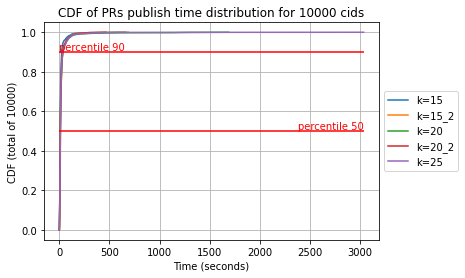

In [3]:
# Comparison of the DHT_Provide times CDF

fig, ax = plt.subplots()

# Iter through DBs
for i, con in enumerate(dbs):
    pobj = pd.read_sql_query("select provide_time from cid_info order by provide_time ASC", con)
    pobj['provide_time'] = pobj['provide_time'] / 1000  # convert to secods
    
    ax.plot(pobj["provide_time"], np.linspace(0, 1, len(pobj)), label=db_labels[i])

# Plot metadata
plt.title(f'CDF of PRs publish time distribution for {len(pobj)} cids')
plt.xlabel("Time (seconds)")
plt.ylabel(f"CDF (total of {cid_number})")

# Legend
plt.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Lines
plt.hlines(y=[0.50], xmin=pobj.iloc[0]['provide_time'], xmax=pobj.iloc[len(pobj)-1]['provide_time'], color='r', linestyle='-', label='50%')
plt.text(pobj.iloc[len(pobj)-1]['provide_time'], 0.525, 'percentile 50', ha='right', va='center', color='r')
plt.hlines(y=[0.90], xmin=pobj.iloc[0]['provide_time'], xmax=pobj.iloc[len(pobj)-1]['provide_time'], color='r', linestyle='-', label='50%')
plt.text(pobj.iloc[0]['provide_time']-0.1, 0.925, 'percentile 90', ha='left', va='center', color='r')

plt.grid()


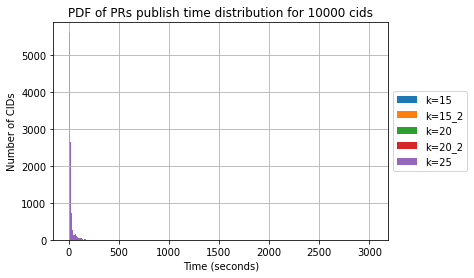

In [4]:
# Comparison of the DHT_Provide times PDF

fig, ax = plt.subplots()

# Iter through DBs
for i, con in enumerate(dbs):
    pobj = pd.read_sql_query("select provide_time from cid_info order by provide_time ASC", con)
    pobj['provide_time'] = pobj['provide_time'] / 1000  # convert to secods
    
    ax.hist(pobj['provide_time'], density=False, bins=150, label=db_labels[i])

plt.title(f'PDF of PRs publish time distribution for {len(pobj)} cids')
plt.xlabel("Time (seconds)")
plt.ylabel(f"Number of CIDs")

# Legend
plt.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.grid()

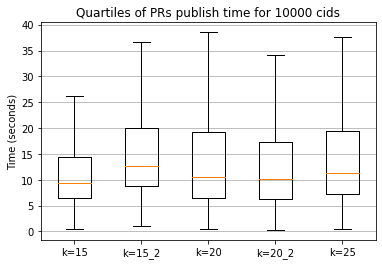

In [5]:
# Comparison of the DHT_Provide times Quartiles

time_dists = []

# Make PostgreSQL query at each of the DB connetions
for i, con in enumerate(dbs):
    pobj = pd.read_sql_query("select provide_time from cid_info order by provide_time ASC", con)
    pobj['provide_time'] = pobj['provide_time'] / 1000  # convert to secods
    time_dists.append(pobj['provide_time'].to_numpy())
    
plt.boxplot(time_dists, showfliers=False)

plt.title(f'Quartiles of PRs publish time for {len(pobj)} cids')
plt.ylabel(f"Time (seconds)")
plt.xticks(box_idxs+1, db_labels)

plt.grid(axis='y')


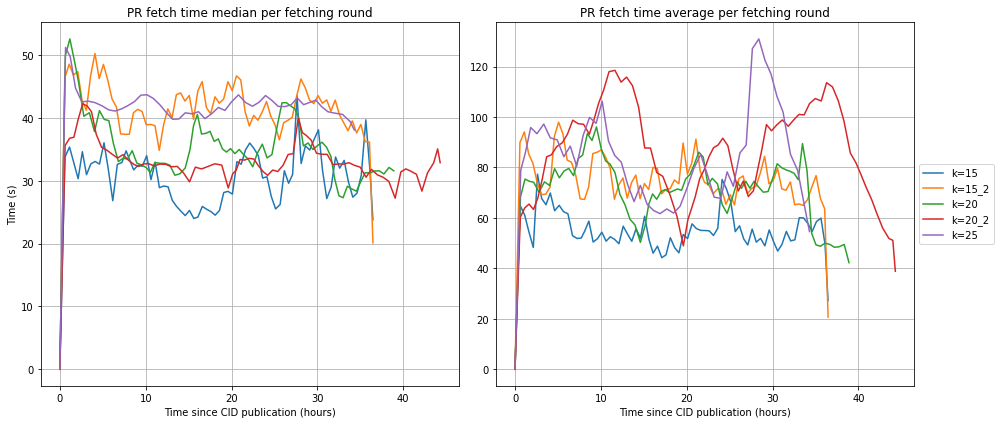

In [6]:
# Compare the time to ping PR Holders

# Get the number of rounds that we hoarded
pings = pd.read_sql_query("select ping_round from fetch_results group by ping_round order by ping_round ASC", dbs[0])

fig, (ax_means, ax_avgs) = plt.subplots(1,2, figsize=(14,6))

# Iter through DBs
for i, con in enumerate(dbs):
    m_dist = []
    a_dist = []
    
    # Get the CID Publish times for the CIDs
    pub_times = pd.read_sql_query("""
        select cid_hash, gen_time from cid_info order by cid_hash;
        """, con)
    
    hours_since_pub = []
    # Get the distribution for each of the rounds
    for idx, row in pings.iterrows():
        
        fpd_round_ftime = pd.read_sql_query(f'select cid_hash, fetch_time, fetch_duration from fetch_results where ping_round={row["ping_round"]} order by cid_hash', con) 
        fpd_round_ftime['fetch_duration'] = fpd_round_ftime['fetch_duration'] / 1000 # to seconds 
        m_dist.append(fpd_round_ftime['fetch_duration'].median())
        a_dist.append(fpd_round_ftime['fetch_duration'].mean())
    
        # calculate the time at wich each ping round was done
        fpd_round_ftime['time of pub'] = (fpd_round_ftime['fetch_time'] - pub_times['gen_time']) / 3600 # get the hours since publish time
        pp = fpd_round_ftime['time of pub'].to_numpy()
        hours_since_pub.append(np.median(pp))
    
    ax_means.plot(hours_since_pub, m_dist, label=db_labels[i])
    ax_avgs.plot(hours_since_pub, a_dist, label=db_labels[i])

# mean
ax_means.set_xlabel("Time since CID publication (hours)")
ax_means.set_ylabel("Time (s)")
ax_means.set_title("PR fetch time median per fetching round")
ax_means.grid()

# avgs
ax_avgs.set_xlabel("Time since CID publication (hours)")
ax_avgs.set_title("PR fetch time average per fetching round")
ax_avgs.grid()

ax_avgs.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

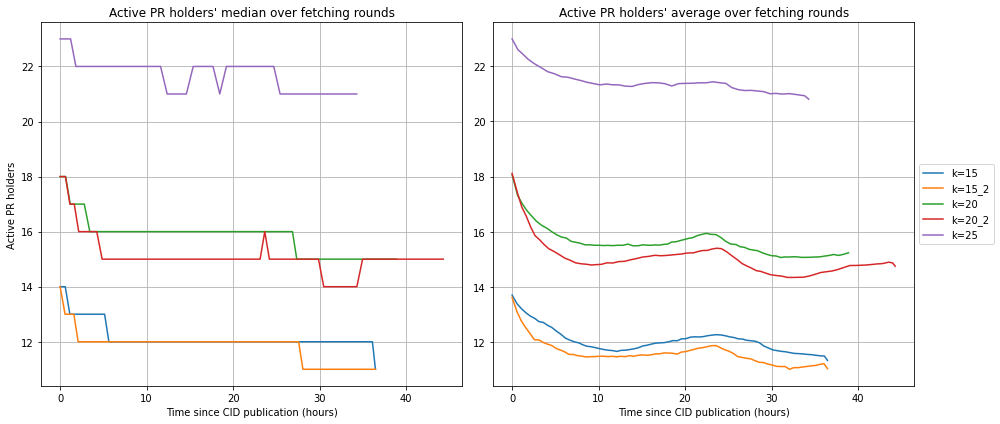

In [7]:
# Compare active PR holders over fetch rounds (just for double check following distributions)

# Get the number of rounds that we hoarded
pings = pd.read_sql_query("select ping_round from fetch_results group by ping_round order by ping_round ASC", dbs[0])

fig, (ax_means, ax_avgs) = plt.subplots(1,2, figsize=(14,6))


# Iter through DBs
for i, con in enumerate(dbs):
    m_dist = []
    a_dist = []
    
    # Get the CID Publish times for the CIDs
    pub_times = pd.read_sql_query("""
        select cid_hash, gen_time from cid_info order by cid_hash;
        """, con)
    
    hours_since_pub = []
    # Get the distribution for each of the rounds
    for idx, row in pings.iterrows():
        p = pd.read_sql_query(f'select cid_hash, fetch_time, success_att from fetch_results where ping_round={row["ping_round"]} order by cid_hash', con) 
        m_dist.append(p['success_att'].median())
        a_dist.append(p['success_att'].mean())
        
        # calculate the time at wich each ping round was done
        p['time of pub'] = (p['fetch_time'] - pub_times['gen_time']) / 3600 # get the hours since publish time
        pp = p['time of pub'].to_numpy()
        hours_since_pub.append(np.median(pp))
    
    ax_means.plot(hours_since_pub, m_dist, label=db_labels[i])
    ax_avgs.plot(hours_since_pub, a_dist, label=db_labels[i])

# mean
ax_means.set_xlabel("Time since CID publication (hours)")
ax_means.set_ylabel("Active PR holders")
ax_means.set_title("Active PR holders' median over fetching rounds")
ax_means.grid()

# avgs
ax_avgs.set_xlabel("Time since CID publication (hours)")
ax_avgs.set_title("Active PR holders' average over fetching rounds")
ax_avgs.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax_avgs.grid()

plt.tight_layout()
plt.show()


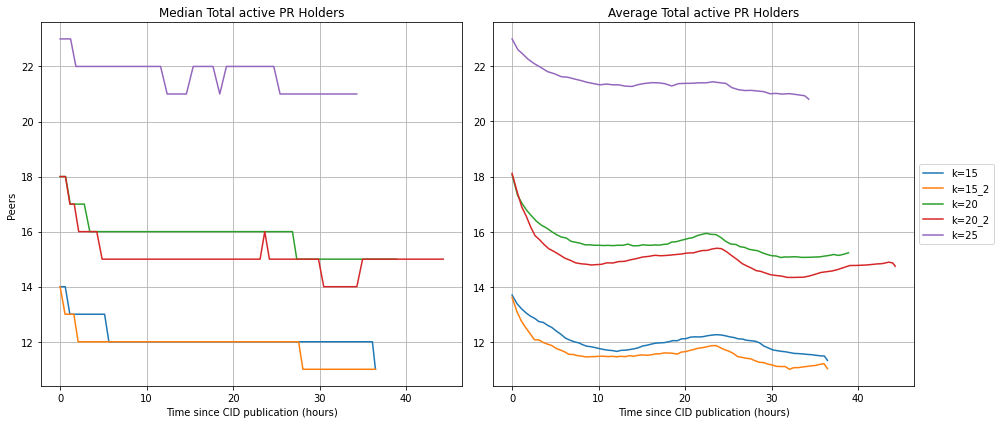

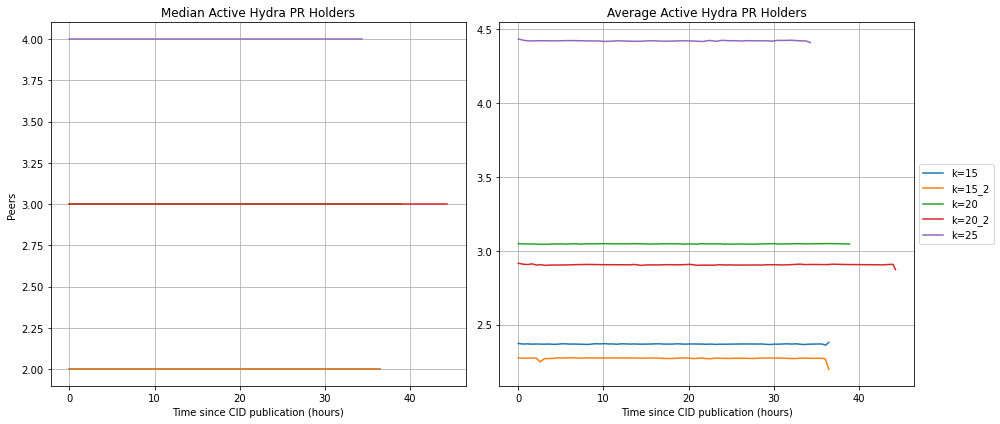

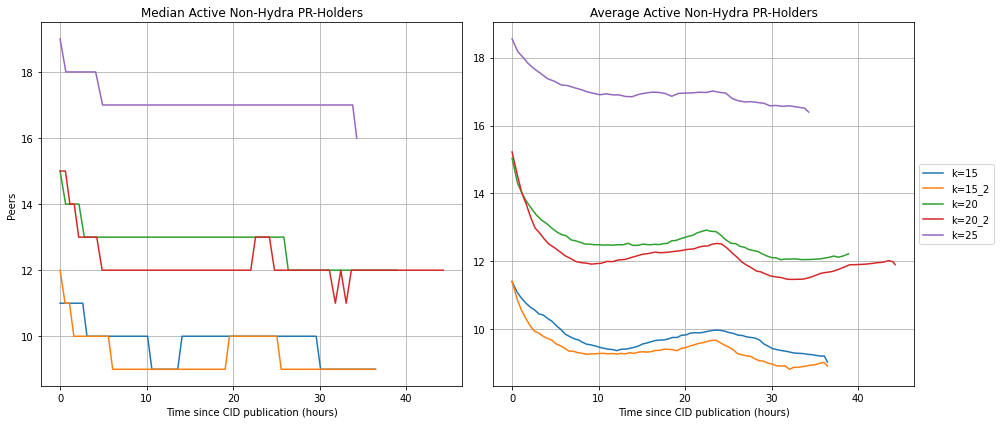

In [15]:
# Compare Active PR holders over fetch rounds total - hydra peers - non-hydra peers
# NOTE: might take serveral minutes to fetch all the data from the DB

# Get the number of rounds that we hoarded
pings = pd.read_sql_query("select ping_round from fetch_results group by ping_round order by ping_round ASC", dbs[0])


query_set = [
   """
   select p.cid_hash, p.ping_round, count(p.is_active) from (
       select r.cid_hash, r.ping_round, r.peer_id, r.is_active from ping_results as r
           left join peer_info as i on r.peer_id=i.peer_id    
   ) as p where p.ping_round={%ping_round%} and p.is_active=true 
   group by p.cid_hash, p.ping_round order by cid_hash;
   """,
   """
   select p.cid_hash, p.ping_round, count(p.is_active) from (
       select r.cid_hash, r.ping_round, r.peer_id, r.is_active, i.client from ping_results as r
       left join peer_info as i on r.peer_id=i.peer_id    
   ) as p where p.ping_round={%ping_round%} and p.is_active=true and p.client='hydra-booster'
   group by p.cid_hash, p.ping_round order by cid_hash;
   """,
    """
    select p.cid_hash, p.ping_round, count(p.is_active) from (
        select r.cid_hash, r.ping_round, r.peer_id, r.is_active, i.client from ping_results as r
        left join peer_info as i on r.peer_id=i.peer_id    
    ) as p where p.ping_round={%ping_round%} and p.is_active=true and p.client!='hydra-booster'
    group by p.cid_hash, p.ping_round order by cid_hash;
    """,
]
title_set = [
    "Total active PR Holders", 
    "Active Hydra PR Holders", 
    "Active Non-Hydra PR-Holders"]


for item, query_item in enumerate(query_set):
    
    fig, (ax_m, ax_a) = plt.subplots(1, 2, figsize=(14,6))
    
    # Iter through DBs
    for i, con in enumerate(dbs):
        m_dist = []
        a_dist = []
                
        # Get the CID Publish times for the CIDs
        pub_times = pd.read_sql_query("""
            select cid_hash, gen_time from cid_info order by cid_hash;
            """, con)
    
        hours_since_pub = []
        # Iterate through ping rounds to get 
        for idx, row in pings.iterrows():
            
            # Calculate the time of pinging each round (to display it hours since publicatoin)
            fetch_round = pd.read_sql_query(f"""
            select cid_hash, fetch_time from fetch_results where ping_round={row['ping_round']} order by cid_hash;
            """, con)
            
            active_p = pd.read_sql_query( query_item.replace('{%ping_round%}', str(row['ping_round'])), con)
            m_dist.append(active_p['count'].median())
            a_dist.append(active_p['count'].mean())

            # calculate the time at wich each ping round was done
            fetch_round['time of pub'] = (fetch_round['fetch_time'] - pub_times['gen_time']) / 3600 # get the hours since publish time
            pp = fetch_round['time of pub'].to_numpy()
            hours_since_pub.append(np.median(pp))
        
        ax_m.plot(hours_since_pub, m_dist, label=db_labels[i])
        ax_a.plot(hours_since_pub, a_dist, label=db_labels[i])
        
    # active hydras vs active no hydras
    # mean
    ax_m.set_title('Median '+title_set[item])
    ax_m.set_xlabel("Time since CID publication (hours)")
    ax_m.set_ylabel("Peers")
    ax_m.grid()

    # avg
    ax_a.set_title('Average '+title_set[item])
    ax_a.set_xlabel("Time since CID publication (hours)")
    ax_a.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax_a.grid()

    plt.tight_layout()
    plt.show()

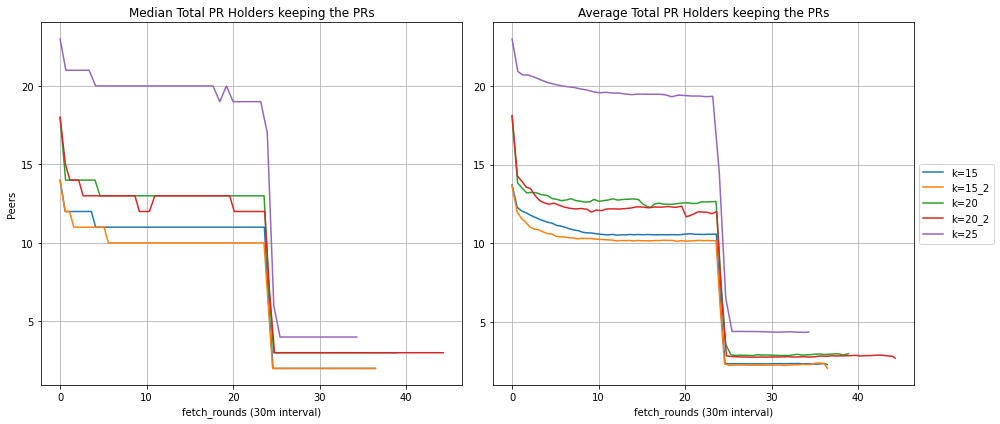

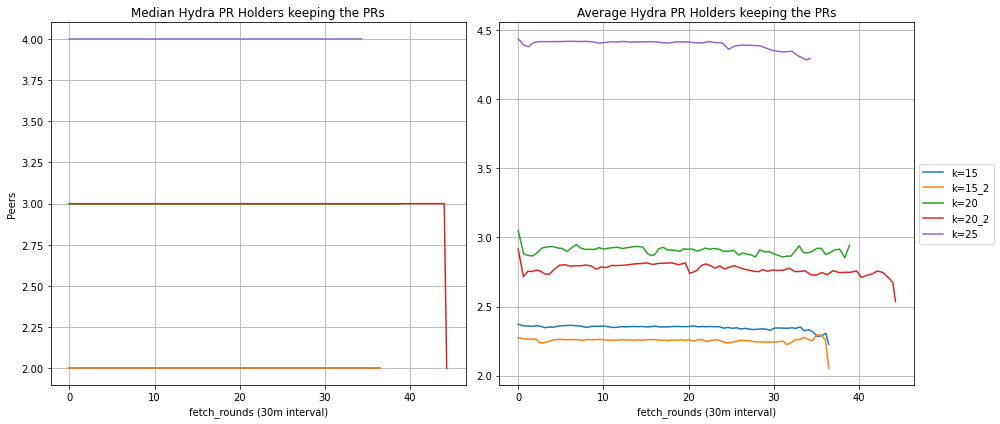

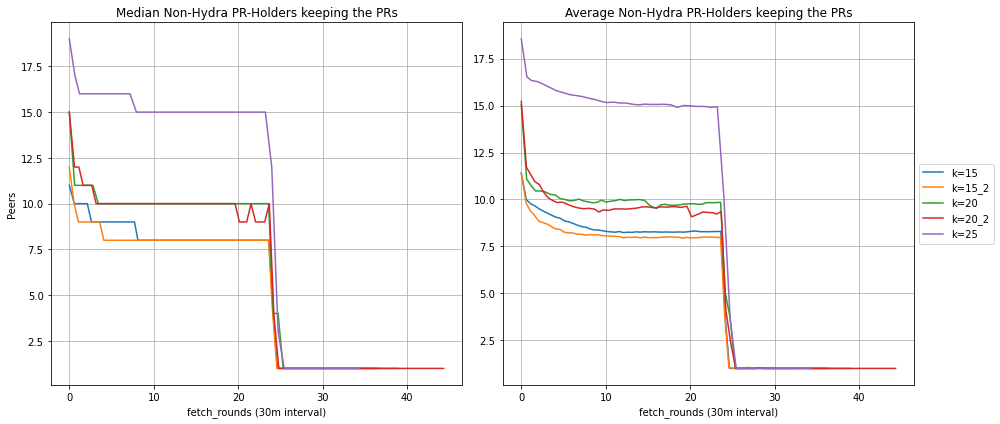

In [16]:
# Compare Active PR holders over fetch rounds total - hydra peers - non-hydra peers

# Get the number of rounds that we hoarded
pings = pd.read_sql_query("select ping_round from fetch_results group by ping_round order by ping_round ASC", dbs[0])

query_set = ["""
    select p.cid_hash, p.ping_round, count(p.has_records) from (
        select r.cid_hash, r.ping_round, r.peer_id, r.has_records from ping_results as r
            left join peer_info as i on r.peer_id=i.peer_id    
    ) as p where p.ping_round={%ping_round%} and p.has_records=true 
    group by p.cid_hash, p.ping_round order by cid_hash;
    """,
    """
    select p.cid_hash, p.ping_round, count(p.has_records) from (
        select r.cid_hash, r.ping_round, r.peer_id, r.has_records, i.client from ping_results as r
        left join peer_info as i on r.peer_id=i.peer_id    
    ) as p where p.ping_round={%ping_round%} and p.has_records=true and p.client='hydra-booster'
    group by p.cid_hash, p.ping_round order by cid_hash;
    """,
    """
    select p.cid_hash, p.ping_round, count(p.has_records) from (
        select r.cid_hash, r.ping_round, r.peer_id, r.has_records, i.client from ping_results as r
        left join peer_info as i on r.peer_id=i.peer_id    
    ) as p where p.ping_round={%ping_round%} and p.has_records=true and p.client!='hydra-booster'
    group by p.cid_hash, p.ping_round order by cid_hash;
    """,
]

title_set = ["Total PR Holders keeping the PRs", "Hydra PR Holders keeping the PRs", "Non-Hydra PR-Holders keeping the PRs"]

for item, query_item in enumerate(query_set):
    
    fig, (ax_m, ax_a) = plt.subplots(1, 2)
    
    # Iter through DBs for each query
    for i, con in enumerate(dbs):
        m_dist = []
        a_dist = []
        
        # Get the CID Publish times for the CIDs
        pub_times = pd.read_sql_query("""
            select cid_hash, gen_time from cid_info order by cid_hash;
            """, con)
        
        hours_dist = []
        
        # Iterate through ping rounds to get 
        for idx, row in pings.iterrows():
            active_p = pd.read_sql_query( query_item.replace('{%ping_round%}', str(row['ping_round'])), con)
            m_dist.append(active_p['count'].median())
            a_dist.append(active_p['count'].mean())
            
            # Calculate the time of pinging each round (to display it hours since publicatoin)
            fetch_round = pd.read_sql_query(f"""
            select cid_hash, fetch_time from fetch_results where ping_round={row['ping_round']} order by cid_hash;
            """, con)
            
            # calculate the time at wich each ping round was done
            fetch_round['time of pub'] = (fetch_round['fetch_time'] - pub_times['gen_time']) / 3600 # get the hours since publish time
            pp = fetch_round['time of pub'].to_numpy()
            hours_dist.append(np.median(pp))
        
        ax_m.plot(hours_dist, m_dist, label=db_labels[i])
        ax_a.plot(hours_dist, a_dist, label=db_labels[i])

    # active hydras vs active no hydras
    # mean
    ax_m.set_title('Median '+title_set[item])
    ax_m.set_xlabel("fetch_rounds (30m interval)") # TODO: hardcoded to 30 mins
    ax_m.set_ylabel("Peers")
    ax.set_ylim(-1, 26)
    ax_m.figure.set_size_inches(14,6)
    ax_m.grid()

    # avg
    ax_a.set_title('Average '+title_set[item])
    ax_a.set_xlabel("fetch_rounds (30m interval)") # TODO: hardcoded to 30 mins
    ax_a.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylim(-1, 26)
    ax_a.figure.set_size_inches(14,6)
    ax_a.grid()

    plt.tight_layout()
    plt.show()


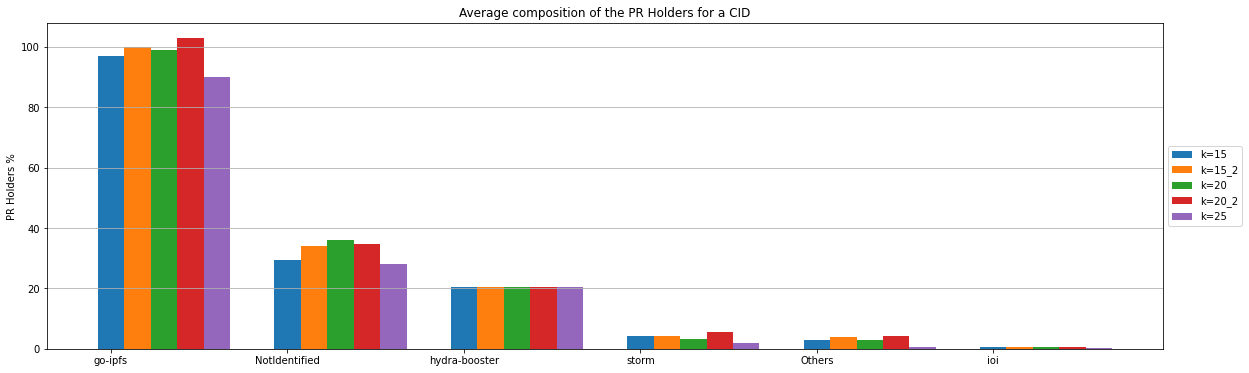

In [13]:
# Compare client distribution among PR Holders

fig, ax = plt.subplots(figsize=(20,6))

width = 0.15

# Iter through DBs
for i, con in enumerate(dbs):
    pobj = pd.read_sql_query("select client, count(client) from peer_info group by client order by count(client) DESC;", con)

    total = 0
    for idx, c in pobj.iterrows():
        total += c["count"]

    # get the percentage of each client
    pobj["client_ratio"] = (pobj["count"] * 100) / cid_number

    # compose labels
    labels = []
    for idx, row in pobj.iterrows():
        r = f'{row["client_ratio"]}% {row["client"]}'
        labels.append(r)

    ax.bar(np.arange(len(pobj['client']))+(width*i), pobj['client_ratio'], width, label=db_labels[i])
    ax.set_xticks(np.arange(len(pobj['client'])), pobj['client'])
    
plt.title("Average composition of the PR Holders for a CID")
plt.ylabel("PR Holders %")
plt.legend()
plt.legend(loc='center left',  bbox_to_anchor=(1, 0.5))
plt.grid(axis='y')



In [ ]:
# Compare the in-degree ratio of PR Holders in K closest peers over fetch rations 
# NOTE: might take several minutes depending on the number of DBs, fetch_rounds and k value

# Formula to compute the in_degree on a PR Holder set into a given K_closest peers set
def get_in_degree(org, new) -> int:
    in_degree = 0
    for new_peer in new:
        if new_peer in org:
            in_degree += 1
    return in_degree

# Get the ping rounds
ping_rounds = pd.read_sql_query("""select ping_round from fetch_results group by ping_round order by ping_round ASC;""", dbs[0])

fig, (ax_m, ax_a) = plt.subplots(1,2, figsize=(14,6))

# Iterate over the existing DBs
for idx, con in enumerate(dbs):
    print(f"db {idx+1}/{len(dbs)}")
    m_dist = []
    a_dist = []
    
    # Get the CID Publish times for the CIDs
    pub_times = pd.read_sql_query("""
        select cid_hash, gen_time from cid_info order by cid_hash;
        """, con)
    
    hours_since_pub = []
    hours_since_pub.append(0)
    
    # Get PR Holders for each CID
    pr_holders = pd.read_sql_query("""select cid_hash, peer_id from pr_holders order by cid_hash;""", con)

    init_holders = {}
    for i, r in pr_holders.iterrows():
        if r['cid_hash'] not in init_holders:
            init_holders[r['cid_hash']] = []
        init_holders[r['cid_hash']].append(r['peer_id'])

    init_in_degree = []
    
    # Get in-degree of the first round - should give 10/10 
    for cid in init_holders:
        in_d = get_in_degree(init_holders[cid], init_holders[cid])
        init_in_degree.append(in_d)

    m_dist.append(np.median(init_in_degree))
    a_dist.append(np.median(init_in_degree))

    for i, r in ping_rounds.iterrows():
        if r['ping_round'] == 0: # first round has no closest peers
            continue
            
        # Calculate the time of pinging each round (to display it hours since publicatoin)
        fetch_round = pd.read_sql_query(f"""
        select cid_hash, fetch_time, fetch_duration from fetch_results where ping_round={r['ping_round']} order by cid_hash;
        """, con)
        
        fetch_round['time of pub'] = (fetch_round['fetch_time'] - pub_times['gen_time']) / 3600 # get the hours since publish time
        pp = fetch_round['time of pub'].to_numpy()
        hours_since_pub.append(np.median(pp))
        
        round_close_peers = {}
        close_peers = pd.read_sql_query(f"""
        select cid_hash, peer_id from k_closest_peers where ping_round={r['ping_round']} order by cid_hash;
        """, con)

        # Filter out the K closest peers by CID
        for i, r in close_peers.iterrows():
            if r['cid_hash'] not in round_close_peers:
                round_close_peers[r['cid_hash']] = []

            round_close_peers[r['cid_hash']].append(r['peer_id'])

        # Get the in-degree of the PR Holders and the rounds of K closest peers
        round_close_p_dist = []
        for c in init_holders:
            in_d = 0
            try:
                in_d = get_in_degree(init_holders[c], round_close_peers[c])    
            except:
                in_d = 0
            round_close_p_dist.append(in_d) 
       
        m_dist.append(np.median(round_close_p_dist))
        a_dist.append(np.mean(round_close_p_dist))
    
    ax_m.plot(hours_since_pub, m_dist, label=db_labels[idx])
    ax_a.plot(hours_since_pub, a_dist, label=db_labels[idx])

# mean
ax_m.set_title('PR holders In-Degree over fetching rounds median')
ax_m.set_xlabel("Time since CID publication (hours)")
ax_m.set_ylabel("PR Holders inside set of closest peers")
ax_m.grid()

# avg
ax_a.set_title('PR holders In-Degree over fetching rounds average')
ax_a.set_xlabel("Time since CID publication (hours)") # TODO: hardcoded to 30 mins
ax_a.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax_a.grid()

plt.tight_layout()
plt.show()


db 1/5
db 2/5
db 3/5
db 4/5


In [ ]:
# Close all the connections with the databases
for con in dbs:
    con.close()